#                               ** Subscriptions Adoption Strategy**

#### **Business Problem/Goal**

>Identify existing merchants who are not using Subscription product but are likely to adopt it if targeted by marketing/sales campaigns

#### **Data Available**
>Payments: Contains merchant-day volume data. Volume is reported for three  products: Subscriptions, Checkout, and Payment Links
>Merchants: Contains merchant data including signup date, region, company size, and industry. 


In [ ]:
#Import the required libraries

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

pd.set_option('display.float_format', '{:.2f}'.format)

#Set the project path
path="/Users/Project"
outputpath="/Users/Project/03-output/"
os.chdir(path)

In [45]:
# Load the data
merchants = pd.read_csv('01-data/dstakehome_merchants.csv')
payments = pd.read_excel('01-data/dstakehome_payments.xlsx')
# merchants_bkup=merchants
# payments_bkup=payments

In [49]:
##A quick look into the merchant data
# print(merchants.info())
print(merchants.isnull().sum())

# merchants.describe()
# merchants[merchants['first_charge_date'].isnull()]

merchant              0
industry              0
first_charge_date    26
country               0
business_size         0
dtype: int64


There are 26 Null Values in the merchant data for the first_charge_date and will keep them as such for now and later impute them based on payments

In [48]:
print(f"\nThe total number of merchants in our data is", merchants['merchant'].nunique())
print(f"\nThe total number of industries in our data is", merchants['industry'].nunique())
print(f"\nThe business_size categories in our data are", merchants['business_size'].unique())

# Convert to date formats
merchants['first_charge_date'] = pd.to_datetime(merchants['first_charge_date'], utc=True,errors='coerce')
merchants['first_charge_date'] = pd.to_datetime(merchants['first_charge_date'].dt.strftime('%Y-%m-%d'))
merchants['merchant'] = payments['merchant'].astype(str)



The total number of merchants in our data is 23619

The total number of industries in our data is 30

The business_size categories in our data are ['medium' 'small' 'large']


In [13]:
# Check for duplicate rows in merchant data based on all columns
merchants['merchant'] = payments['merchant'].astype(str)

duplicate_rows = merchants[merchants.duplicated()]

print(f"Number of duplicate rows in merchant_data: {duplicate_rows.shape[0]}")

# check duplicates based on merchant only
duplicate_merchants = merchants[merchants.duplicated(subset=['merchant'], keep=False)]

print(f"Number of duplicated merchant IDs in merchant_data: {duplicate_merchants['merchant'].nunique()}")
print(merchants.groupby('merchant')['industry'].nunique().value_counts())
print(merchants.groupby('merchant')['country'].nunique().value_counts())

duplicate_merchants.sort_values(by="merchant")
merchants.groupby('merchant')['business_size'].nunique().value_counts()

Number of duplicate rows in merchant_data: 0
Number of duplicated merchant IDs in merchant_data: 4891
industry
1    2284
2    1236
3     927
5     913
4     824
6     705
7     225
Name: count, dtype: int64
country
1    2475
2    1447
3    1169
4    1019
5     704
6     261
7      39
Name: count, dtype: int64


business_size
1    6459
2     634
3      21
Name: count, dtype: int64

### Handling Multiple Merchant Attributes

The payment data aggregates transaction volumes by merchant but lacks detailed breakdowns by country or industry. Conversely, the merchant dataset contains multiple rows per merchant reflecting different countries and industries. We remove these later after merging with the payment data to avoid inflation



In [14]:
##A quick look into the payments data and convert date to proper dateformats and the cents to dollars in all monetary columns
print(payments.info())
print(payments.isnull().sum())

print(f"\nThe total number of merchants in our data is", payments['merchant'].nunique())


payments['date'] = pd.to_datetime(payments['date'], utc=True,errors='coerce')
payments['date'] = pd.to_datetime(payments['date'].dt.strftime('%Y-%m-%d'))
payments['merchant'] = payments['merchant'].astype(str)

print(f"\nThe oldest date in our data is", payments['date'].min())
print(f"\nThe latest date in our data is", payments['date'].max())


monetary_cols = ['subscription_volume', 'checkout_volume', 'payment_link_volume', 'total_volume']
payments[monetary_cols] = payments[monetary_cols].div(100).round(2)
payments.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1577887 entries, 0 to 1577886
Data columns (total 6 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   date                 1577887 non-null  object
 1   merchant             1577887 non-null  object
 2   subscription_volume  1577887 non-null  int64 
 3   checkout_volume      1577887 non-null  int64 
 4   payment_link_volume  1577887 non-null  int64 
 5   total_volume         1577887 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 72.2+ MB
None
date                   0
merchant               0
subscription_volume    0
checkout_volume        0
payment_link_volume    0
total_volume           0
dtype: int64

The total number of merchants in our data is 23620

The oldest date in our data is 2041-05-01 00:00:00

The latest date in our data is 2042-06-22 00:00:00


,date,subscription_volume,checkout_volume,payment_link_volume,total_volume
count,1577887,1577887.00,1577887.00,1577887.00,1577887.00
mean,2041-12-02 00:57:55.029073408,392.48,110.14,18.44,3582.91
min,2041-05-01 00:00:00,0.00,0.00,0.00,0.01
25%,2041-08-21 00:00:00,0.00,0.00,0.00,60.00
50%,2041-12-05 00:00:00,0.00,0.00,0.00,198.72
75%,2042-03-17 00:00:00,0.00,0.00,0.00,723.00
max,2042-06-22 00:00:00,1083879.03,342590.69,118290.00,22438104.82
std,NaN,7253.65,1608.57,371.77,64886.84


It looks like the total volume in the payments data isn't the sum of the 3 product volumes, for the sake of this analysis I will create a new column total_volume and use it for further analysis

In [15]:
# print(payments.head(6))
payments['total_volume']=payments['subscription_volume']+payments['payment_link_volume']+payments['checkout_volume']
print(payments['total_volume'].sum()/1000000)

822.1630885300001


In [16]:
# Check date ranges
print("\nDate ranges in merchants data:")
print(f"Earliest first_charge_date: {merchants['first_charge_date'].min()}")
print(f"Latest first_charge_date: {merchants['first_charge_date'].max()}")

print("\nDate ranges in payments data:")
print(f"Earliest payment date: {payments['date'].min()}")
print(f"Latest payment date: {payments['date'].max()}")


Date ranges in merchants data:
Earliest first_charge_date: 2030-11-07 00:00:00
Latest first_charge_date: 2042-06-22 00:00:00

Date ranges in payments data:
Earliest payment date: 2041-05-01 00:00:00
Latest payment date: 2042-06-22 00:00:00


In [17]:
# Check for negative volumes
print("\nNegative volume checks:")
print(f"Negative subscription volumes: {(payments['subscription_volume'] < 0).sum()}")
print(f"Negative checkout volumes: {(payments['checkout_volume'] < 0).sum()}")
print(f"Negative payment_link volumes: {(payments['payment_link_volume'] < 0).sum()}")


Negative volume checks:
Negative subscription volumes: 0
Negative checkout volumes: 0
Negative payment_link volumes: 0


In [18]:
##Check to see if all merchants from the payment data are present in the merchant dataset

missing_merchants = payments[~payments['merchant'].isin(merchants['merchant'])]['merchant'].unique()
print("Missing merchants:", missing_merchants)
print("Count of Missing merchants from the merchant data which have payment information:",len(missing_merchants))

Missing merchants: ['bce6cb54' '8ac52dc7' '535aecd2' ... '5b4f584e' '4807c040' 'e289a7fc']
Count of Missing merchants from the merchant data which have payment information: 16506


In [19]:
# Checking the sum of the total volume of the missing merchants 
missing_volume = payments[payments['merchant'].isin(missing_merchants)]['total_volume'].sum()
total_volume=payments['total_volume'].sum()
print("Total volume of all merchants:", total_volume/1000000)
print("Total volume of missing merchants:", missing_volume/1000000)
print("Perc of missing merchants metadata:", missing_volume/total_volume*100)

Total volume of all merchants: 822.1630885300001
Total volume of missing merchants: 93.75183346000001
Perc of missing merchants metadata: 11.403070116857853


##### **Observation:
Out of 23620 unique merchant IDs in the payments dataset, approximately 16506 do not have corresponding entries in the merchant dataset.

Implication:
This means over two-thirds of merchants making transactions have no additional metadata available. Therefore, our analysis and targeting strategy is limited to the subset of merchants with complete data.
Only 11% of total volume is coming from the missing merchants

For the sake of this analysis we proceed with analysis on the ~8,000 merchants for whom we have both transactional and metadata, assuming this subset is representative of broader merchant behavior. This is a necessary constraint given the data provided.**

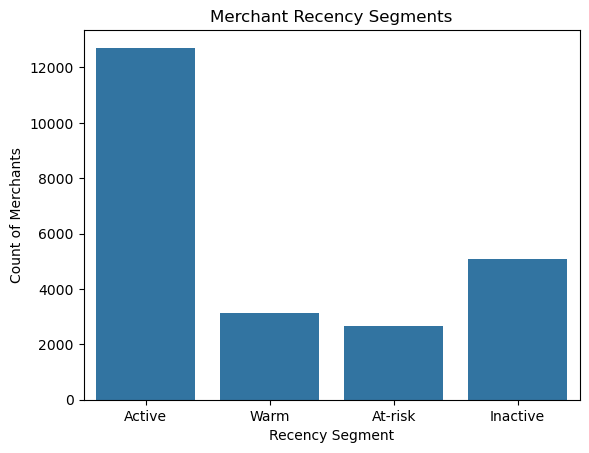

In [20]:
###Creating some useful metrics for our analysis

latest_date = payments['date'].max()

# Check merchant age to see how stable each merchant is
merchants['merchant_age_days'] = (latest_date - merchants['first_charge_date']).dt.days
merchants[['merchant', 'first_charge_date', 'merchant_age_days']].head()

# Aggregate by merchant
agg_payments = payments.groupby('merchant').agg(
    subscription_volume=('subscription_volume', 'sum'),
    checkout_volume=('checkout_volume', 'sum'),
    payment_link_volume=('payment_link_volume', 'sum'),
    total_volume=('total_volume','sum'),
    active_days=('date', 'nunique'),  # Number of unique active days
    first_active_date=('date', 'min'),
    last_active_date=('date', 'max')
).reset_index()

agg_payments['days_since_last_active'] = (latest_date - agg_payments['last_active_date']).dt.days

##flag if they were active in the last 90 days
agg_payments['recently_active'] = agg_payments['days_since_last_active'] <= 90


# Define recency segment based on days since last active, this logic can be modified a bit if the business wants to define recency in a different way
def assign_recency_segment(days):
    if days <= 30:
        return 'Active'
    elif days <= 90:
        return 'Warm'
    elif days <= 180:
        return 'At-risk'
    else:
        return 'Inactive'

# Apply it
agg_payments['recency_segment'] = agg_payments['days_since_last_active'].apply(assign_recency_segment)

sns.countplot(data=agg_payments, x='recency_segment', order=['Active', 'Warm', 'At-risk', 'Inactive'])
plt.title('Merchant Recency Segments')
plt.xlabel('Recency Segment')
plt.ylabel('Count of Merchants')
plt.show()

It looks like most of our merchants are active which is a good sign to move forward with this analysis
Now, we can merge our two datasets and have a merged dataframe with only those merchants that are present in both datasets

In [21]:
merged_df_raw = merchants.merge(agg_payments, on="merchant", how="inner")
print(f"\nThe total number of unique merchants in our data is", merged_df_raw['merchant'].nunique())


The total number of unique merchants in our data is 7114


The below step is to keep only one row per merchant as during merging the number of rows per some merchants were multiplied as the merchant data had multiple countries, business size and industries but we didn't have the corresponding data in the payments data to merge on these

In [22]:
#  Sort merged data by 'merchant' and 'total_volume' descending
merged_sorted = merged_df_raw.sort_values(by=['merchant', 'total_volume'], ascending=[True, False])

# Drop duplicates, keeping the first 
merged_df = merged_sorted.drop_duplicates(subset=['merchant'], keep='first').reset_index(drop=True)
merged_df

,merchant,industry,first_charge_date,country,business_size,merchant_age_days,subscription_volume,checkout_volume,payment_link_volume,total_volume,active_days,first_active_date,last_active_date,days_since_last_active,recently_active,recency_segment
0,00085cb5,Construction,2041-05-25,US,small,393.00,0.00,51600.00,0.00,51600.00,48,2041-05-03,2042-06-07,15,True,Active
1,0015c036,Charity,2036-11-17,US,small,2043.00,162.00,138.00,0.00,300.00,68,2041-05-06,2042-05-09,44,True,Warm
2,0017adb3,Business services,2042-05-27,US,small,26.00,0.00,0.00,0.00,0.00,26,2041-05-07,2042-05-06,47,True,Warm
3,0018ab92,Others,2040-04-15,US,small,798.00,24768.26,0.00,0.00,24768.26,402,2041-05-01,2042-06-22,0,True,Active
4,001f41bc,Business services,2034-11-26,CA,small,2765.00,11933.36,0.00,0.00,11933.36,412,2041-05-01,2042-06-22,0,True,Active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,ffc232ca,Merchandise,2039-03-27,FR,small,1183.00,0.00,0.00,0.00,0.00,138,2041-05-04,2042-06-20,2,True,Active
7110,ffc96fb4,Merchandise,2041-02-16,GB,small,491.00,0.00,0.00,0.00,0.00,111,2041-05-02,2042-06-21,1,True,Active
7111,ffcf1800,Merchandise,2032-06-13,US,small,3661.00,0.00,0.00,0.00,0.00,177,2041-05-03,2042-06-22,0,True,Active
7112,ffe98e3f,Merchandise,2039-01-03,IT,small,1266.00,0.00,0.00,0.00,0.00,369,2041-05-02,2042-06-05,17,True,Active


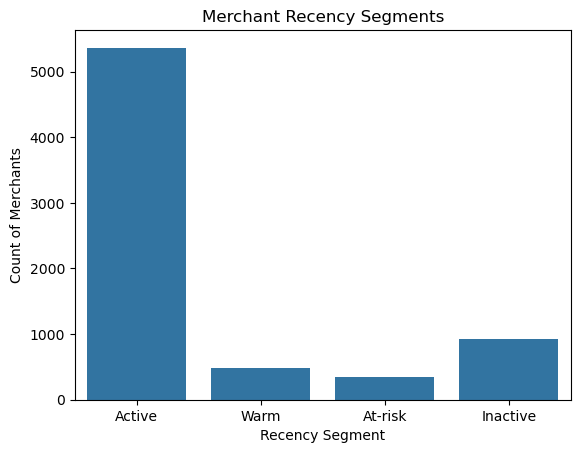

In [23]:
sns.countplot(data=merged_df, x='recency_segment', order=['Active', 'Warm', 'At-risk', 'Inactive'])
plt.title('Merchant Recency Segments')
plt.xlabel('Recency Segment')
plt.ylabel('Count of Merchants')
plt.show()

In [24]:
# Missing values in first_charge_date (26 cases) were imputed using first_active_date
merged_df[merged_df['first_charge_date'].isnull()]
merged_df['first_charge_date'] = merged_df['first_charge_date'].fillna(merged_df['first_active_date'])
print(merged_df.isnull().sum())
merged_df['merchant_age_days'] = merged_df['merchant_age_days'].fillna((latest_date - merged_df['first_charge_date']).dt.days)

merchant                  0
industry                  0
first_charge_date         0
country                   0
business_size             0
merchant_age_days         3
subscription_volume       0
checkout_volume           0
payment_link_volume       0
total_volume              0
active_days               0
first_active_date         0
last_active_date          0
days_since_last_active    0
recently_active           0
recency_segment           0
dtype: int64


In [25]:
# Validate that all payment dates are after first charge date for each merchant
merged_check = merged_df[merged_df['first_active_date'] < merged_df['first_charge_date']]
if not merged_check.empty:
    print(f"\nWarning: {len(merged_check)} merchants have payment dates before their first charge date")
else:
    print("\nAll payment dates occur after first charge date - validation passed")

In [26]:
# Get earliest payment date per merchant
min_payment_date = merged_df.groupby('merchant')['first_active_date'].min().reset_index()
min_payment_date.rename(columns={'first_active_date': 'true_first_activity'}, inplace=True)

# Merge it back
merged_df = merged_df.merge(min_payment_date, on='merchant', how='left')

# Update first_charge_date if it's later than true activity
merged_df['first_charge_date'] = merged_df.apply(
    lambda row: row['true_first_activity'] if pd.notna(row['first_charge_date']) and row['first_charge_date'] > row['true_first_activity']
    else row['first_charge_date'], axis=1
)

In [27]:
def format_summary_table(df, count_col, volume_col, volume_millions_col):
    formatted = df.copy()
    formatted[count_col] = formatted[count_col].map('{:,}'.format)
    formatted[volume_col] = formatted[volume_col].map('{:,.0f}'.format)
    formatted[volume_millions_col] = formatted[volume_millions_col].map('{:,.2f}'.format)
    return formatted
    
def plot_and_table(df, category_col, count_col='merchant_count', volume_col='total_volume', volume_millions_col='total_volume_millions'):
    # Plot
    fig, ax = plt.subplots(figsize=(8,4))

    # Normalize volumes for scale comparison in the plot (optional but helpful)
    max_count = df[count_col].max()
    max_volume = df[volume_col].max()
    scale_factor = max_count / max_volume if max_volume > 0 else 1

    # Bars for count
    sns.barplot(data=df, x=category_col, y=count_col, color='skyblue', label='Count', ax=ax)

    # Bars for scaled volume on same plot with secondary axis
    ax2 = ax.twinx()
    sns.barplot(data=df, x=category_col, y=volume_col, color='orange', alpha=0.6, label='Total Volume', ax=ax2)

    # Legends
    ax.legend(loc='upper left')
    ax2.legend(loc='upper right')

    ax.set_ylabel('Merchant Count')
    ax2.set_ylabel('Total Volume (in cents)')
    plt.title(f'Merchant Count and Total Volume by {category_col.capitalize()}')
    plt.show()

    # Format and display the table
    formatted_table = format_summary_table(df, count_col, volume_col, volume_millions_col)
    display(formatted_table)


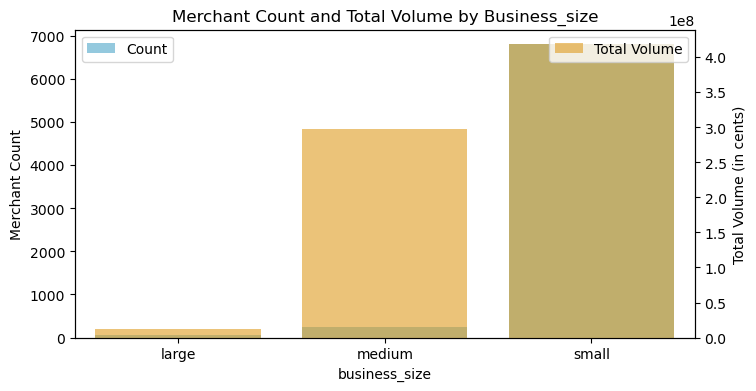

,business_size,merchant_count,total_volume,total_volume_millions
0,large,56,"11,863,587",11.86
1,medium,252,"298,110,962",298.11
2,small,"6,806","418,436,706",418.44


In [28]:
# Summarize by business_size
summary_bs = merged_df.groupby('business_size').agg(
    merchant_count=('merchant', 'count'),
    total_volume=('total_volume', 'sum')
).reset_index()

summary_bs['total_volume_millions'] = summary_bs['total_volume'] / 1_000_000

# Call plotting and table function
plot_and_table(summary_bs, 'business_size')


It looks like most of our merchants are sitting in the small business size companies and are contributing more towards our volume as well

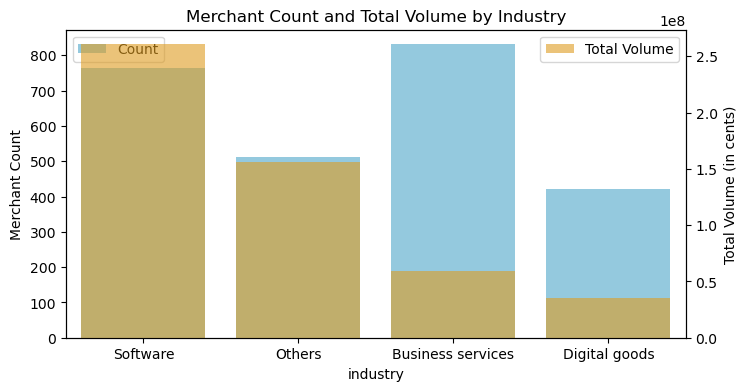

,industry,merchant_count,total_volume,total_volume_millions
25,Software,763,"260,616,657",260.62
21,Others,511,"155,860,747",155.86
3,Business services,831,"59,103,143",59.10
9,Digital goods,422,"35,192,387",35.19


In [29]:
top_n = 4
summary_industry = merged_df.groupby('industry').agg({
    'merchant': 'count',
    'total_volume': 'sum'
}).rename(columns={'merchant': 'merchant_count'}).reset_index()

summary_industry['total_volume_millions'] = summary_industry['total_volume'] / 1_000_000
top_industries = summary_industry.sort_values('total_volume', ascending=False).head(top_n)

plot_and_table(top_industries, 'industry')


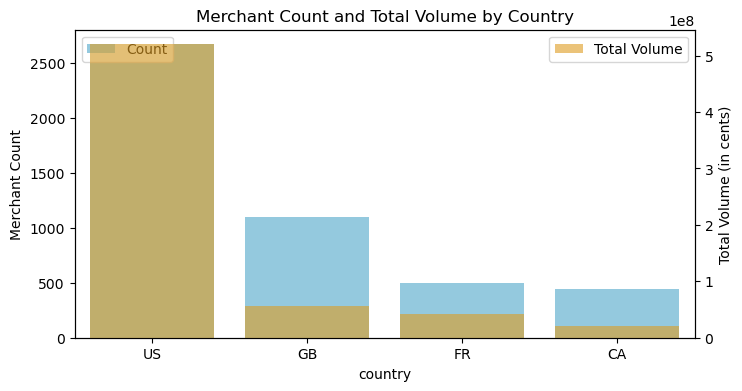

,country,merchant_count,total_volume,total_volume_millions
40,US,"2,671","519,874,933",519.87
16,GB,"1,100","56,571,092",56.57
15,FR,498,"42,278,554",42.28
6,CA,440,"21,285,577",21.29


In [30]:
top_n = 4
summary_countries = merged_df.groupby('country').agg({
    'merchant': 'count',
    'total_volume': 'sum'
}).rename(columns={'merchant': 'merchant_count'}).reset_index()

summary_countries['total_volume_millions'] = summary_countries['total_volume'] / 1_000_000
top_countries = summary_countries.sort_values('total_volume', ascending=False).head(top_n)

plot_and_table(top_countries, 'country')


In [31]:
# Calculate share of each product
merged_df['subscription_share'] = merged_df['subscription_volume'] / merged_df['total_volume']
merged_df['checkout_share'] = merged_df['checkout_volume'] / merged_df['total_volume']
merged_df['payment_link_share'] = merged_df['payment_link_volume'] / merged_df['total_volume']

# Calculate average volume per day based on active days and lifetime
merged_df['avg_volume_per_day'] = merged_df['total_volume'] / merged_df['active_days']
merged_df['avg_volume_per_day_lifetime'] = merged_df['total_volume'] / merged_df['merchant_age_days']


# Preview the key columns
merged_df[['merchant', 'subscription_share', 'checkout_share', 'payment_link_share',
           'avg_volume_per_day', 'avg_volume_per_day_lifetime']].head()


,merchant,subscription_share,checkout_share,payment_link_share,avg_volume_per_day,avg_volume_per_day_lifetime
0,00085cb5,0.00,1.00,0.00,1075.00,131.30
1,0015c036,0.54,0.46,0.00,4.41,0.15
2,0017adb3,NaN,NaN,NaN,0.00,0.00
3,0018ab92,1.00,0.00,0.00,61.61,31.04
4,001f41bc,1.00,0.00,0.00,28.96,4.32


In [32]:
# Total unique merchants
total_merchants = merged_df['merchant'].nunique()

# Merchants with any subscription usage
merchants_with_subscription = merged_df[merged_df['subscription_share'] > 0]['merchant'].nunique()

# Merchants with no subscription usage
merchants_without_subscription = total_merchants - merchants_with_subscription

# Sum volumes for each product in millions
subscription_volume_m = merged_df['subscription_volume'].sum() / 1_000_000
checkout_volume_m = merged_df['checkout_volume'].sum() / 1_000_000
payment_link_volume_m = merged_df['payment_link_volume'].sum() / 1_000_000
total_link_volume_m=merged_df['total_volume'].sum() / 1_000_000

# Build summary as a list of rows
summary_data = [
    {'Category': 'Volume in Millions', 'Metric': 'Subscription', 'Value': round(subscription_volume_m, 2)},
    {'Category': 'Volume in Millions', 'Metric': 'Checkout', 'Value': round(checkout_volume_m, 2)},
    {'Category': 'Volume in Millions', 'Metric': 'Payment Link', 'Value': round(payment_link_volume_m, 2)},
    {'Category': 'Volume in Millions', 'Metric': 'Total Volume', 'Value': round(total_link_volume_m, 2)},
    {'Category': 'Merchant Count', 'Metric': 'Total Unique Merchants', 'Value': total_merchants},
    {'Category': 'Merchant Count', 'Metric': 'Used Subscription', 'Value': merchants_with_subscription},
    {'Category': 'Merchant Count', 'Metric': 'Not Used Subscription', 'Value': merchants_without_subscription},
]
# Convert to DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the result
display(summary_df)

,Category,Metric,Value
0,Volume in Millions,Subscription,593.33
1,Volume in Millions,Checkout,128.51
2,Volume in Millions,Payment Link,6.58
3,Volume in Millions,Total Volume,728.41
4,Merchant Count,Total Unique Merchants,7114.00
5,Merchant Count,Used Subscription,1844.00
6,Merchant Count,Not Used Subscription,5270.00


#### Key Observations from Volume and Merchant Breakdown

>Dominance of Subscription Volume: Subscription-based transactions account for a significant majority of the total volume of over $590 million, which is 84% of all recorded volume. This highlights the high value associated with merchants who have already adopted the Subscriptions product.

>Limited Adoption Across Merchant Base: Out of 7,114 total merchants, only 1,844 (26%) currently use the Subscriptions product. The remaining 5,270 merchants (74%) have not yet adopted it, representing a large untapped opportunity.

>High Potential for Growth: While the merchant adoption rate is relatively low, the stark contrast between volume contribution of users vs. non-users of Subscription suggests that targeting even a subset of the non-user group could yield substantial business impact.

>Checkout and Payment Link Volumes: Checkout contributes around 709 million and Payment Link about $32 million, indicating other usage patterns but at a much smaller scale compared to Subscriptions.

#### This ends the exploratory data analysis for our data and now we have the below dataset to be used for indentifying the potential merchants for subscription

In [33]:
merged_df

,merchant,industry,first_charge_date,country,business_size,merchant_age_days,subscription_volume,checkout_volume,payment_link_volume,total_volume,...,last_active_date,days_since_last_active,recently_active,recency_segment,true_first_activity,subscription_share,checkout_share,payment_link_share,avg_volume_per_day,avg_volume_per_day_lifetime
0,00085cb5,Construction,2041-05-03,US,small,393.00,0.00,51600.00,0.00,51600.00,...,2042-06-07,15,True,Active,2041-05-03,0.00,1.00,0.00,1075.00,131.30
1,0015c036,Charity,2036-11-17,US,small,2043.00,162.00,138.00,0.00,300.00,...,2042-05-09,44,True,Warm,2041-05-06,0.54,0.46,0.00,4.41,0.15
2,0017adb3,Business services,2041-05-07,US,small,26.00,0.00,0.00,0.00,0.00,...,2042-05-06,47,True,Warm,2041-05-07,NaN,NaN,NaN,0.00,0.00
3,0018ab92,Others,2040-04-15,US,small,798.00,24768.26,0.00,0.00,24768.26,...,2042-06-22,0,True,Active,2041-05-01,1.00,0.00,0.00,61.61,31.04
4,001f41bc,Business services,2034-11-26,CA,small,2765.00,11933.36,0.00,0.00,11933.36,...,2042-06-22,0,True,Active,2041-05-01,1.00,0.00,0.00,28.96,4.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7109,ffc232ca,Merchandise,2039-03-27,FR,small,1183.00,0.00,0.00,0.00,0.00,...,2042-06-20,2,True,Active,2041-05-04,NaN,NaN,NaN,0.00,0.00
7110,ffc96fb4,Merchandise,2041-02-16,GB,small,491.00,0.00,0.00,0.00,0.00,...,2042-06-21,1,True,Active,2041-05-02,NaN,NaN,NaN,0.00,0.00
7111,ffcf1800,Merchandise,2032-06-13,US,small,3661.00,0.00,0.00,0.00,0.00,...,2042-06-22,0,True,Active,2041-05-03,NaN,NaN,NaN,0.00,0.00
7112,ffe98e3f,Merchandise,2039-01-03,IT,small,1266.00,0.00,0.00,0.00,0.00,...,2042-06-05,17,True,Active,2041-05-02,NaN,NaN,NaN,0.00,0.00


### Clustering to group similar merchants on the basis of the available features 

>Note I tried removing and adding different features and the below result seemed to be a good fit to categorize with the available data

Chose clusters via the elbow method 

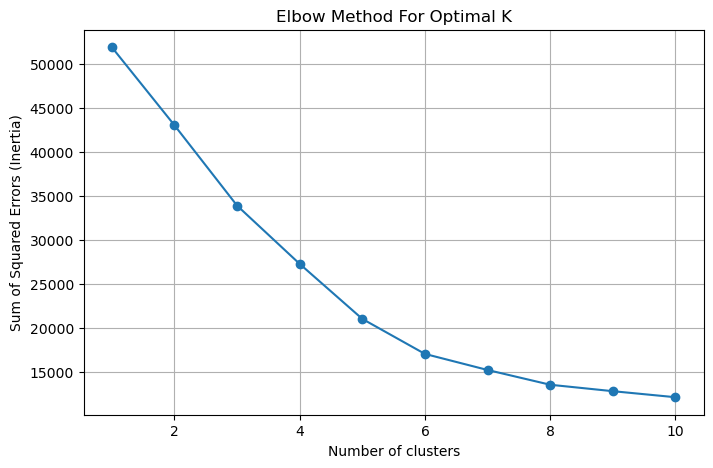

In [34]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

features_num = ['subscription_share', 'checkout_share', 'payment_link_share',
                'avg_volume_per_day', 'avg_volume_per_day_lifetime',
                'active_days','merchant_age_days']

# features_cat = ['industry', 'business_size', 'country']
features_cat = ['industry','business_size']

# Cap numeric features at 99th percentile
for col in features_num:
    upper_limit = merged_df[col].quantile(0.99)
    merged_df.loc[merged_df[col] > upper_limit, col] = upper_limit

merged_df[features_num] = merged_df[features_num].fillna(0)

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_num),
        ('cat', OneHotEncoder(handle_unknown='ignore'), features_cat)
    ])
X_preprocessed = preprocessor.fit_transform(merged_df)

# Step 1: Convert sparse matrix to dense (if needed)
X_dense = X_preprocessed.toarray()

# Step 2: Reduce dimensions for clustering (e.g., to 10)
pca = PCA(n_components=10, random_state=42)
X_reduced = pca.fit_transform(X_dense)

# Step 3: Elbow Method to choose optimal clusters
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_reduced)
    sse.append(kmeans.inertia_)

# Step 4: Plot Elbow Chart
plt.figure(figsize=(8, 5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Errors (Inertia)')
plt.title('Elbow Method For Optimal K')
plt.grid(True)
plt.show()


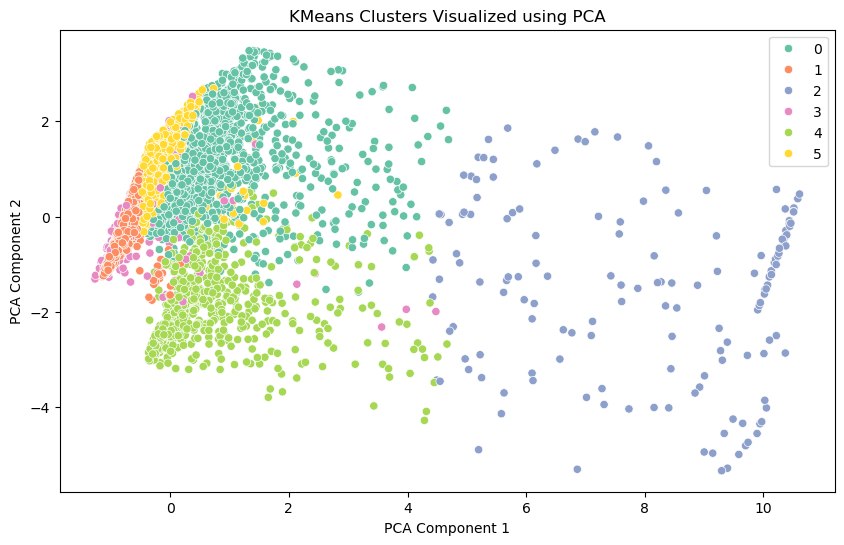

In [35]:
###I should have chosen 8 clusters but the differentiation seem to be better at 6

# KMeans with optimal K
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_reduced)

# 2D PCA for plotting
X_2d = PCA(n_components=2).fit_transform(X_reduced)
# Assign clusters back to your dataframe
merged_df['cluster'] = kmeans.labels_

# StepPlot clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=clusters, palette='Set2')
plt.title('KMeans Clusters Visualized using PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()


In [36]:
cluster_summary = merged_df.groupby('cluster').agg({
    'subscription_share': 'mean',
    'checkout_share': 'mean',
    'payment_link_share': 'mean',
    'avg_volume_per_day': 'mean',
    'avg_volume_per_day_lifetime': 'mean',
    'active_days': 'mean',
    'days_since_last_active': 'mean',
    'industry': lambda x: x.mode()[0],
    'business_size': lambda x: x.mode()[0],
    'country': lambda x: x.mode()[0],
    'merchant_age_days': 'mean'
}).reset_index()

cluster_summary

,cluster,subscription_share,checkout_share,payment_link_share,avg_volume_per_day,avg_volume_per_day_lifetime,active_days,days_since_last_active,industry,business_size,country,merchant_age_days
0,0,0.97,0.02,0.01,270.10,47.44,175.28,32.09,Software,small,US,1237.62
1,1,0.01,0.00,0.00,0.87,0.06,64.01,96.81,Business services,small,US,707.67
2,2,0.69,0.30,0.02,3333.04,1102.34,338.78,4.53,Software,small,US,1293.20
3,3,0.06,0.01,0.93,120.20,26.16,175.08,25.90,Business services,small,US,932.57
4,4,0.07,0.92,0.00,316.09,84.96,172.09,50.72,Software,small,US,905.16
5,5,0.01,0.01,0.00,3.63,1.09,299.71,8.48,Food & drink,small,US,1424.64


In [37]:
# Add normalized scores to merged_df (already done earlier)
merged_df['subscription_score'] = 1 - merged_df['subscription_share']
merged_df['volume_score'] = merged_df['avg_volume_per_day'] / merged_df['avg_volume_per_day'].max()
merged_df['activity_score'] = merged_df['active_days'] / merged_df['active_days'].max()
merged_df['recency_score'] = 1 - (merged_df['days_since_last_active'] / merged_df['days_since_last_active'].max())
merged_df['age_score'] = merged_df['merchant_age_days'] / merged_df['merchant_age_days'].max()

# Compute cluster-level summary including count
cluster_summary = merged_df.groupby('cluster').agg({
    'merchant': 'nunique',
    'subscription_share': 'mean',
    'avg_volume_per_day': 'mean',
    'active_days': 'mean',
    'days_since_last_active': 'mean',
    'merchant_age_days': 'mean',
    'subscription_score': 'mean',
    'volume_score': 'mean',
    'activity_score': 'mean',
    'recency_score': 'mean',
    'age_score': 'mean'
}).reset_index().rename(columns={'merchant': 'merchant_count'})

# Calculate priority score at the cluster level, we can use different thresholds as per the business goals
cluster_summary['priority_score_clu'] = (
    0.45 * cluster_summary['subscription_score'] + 
    0.30 * cluster_summary['volume_score'] + 
    0.15 * cluster_summary['activity_score'] + 
    0.05 * cluster_summary['recency_score'] + 
    0.05 * cluster_summary['age_score']
)

# Sort clusters by priority
cluster_summary_sorted = cluster_summary.sort_values(by='priority_score_clu', ascending=False)

# Display relevant columns
cluster_summary_sorted = cluster_summary_sorted[['cluster', 'merchant_count', 'subscription_share', 
                                                 'avg_volume_per_day', 'active_days', 
                                                 'days_since_last_active', 'merchant_age_days',
                                                 'priority_score_clu']]
cluster_summary_sorted

,cluster,merchant_count,subscription_share,avg_volume_per_day,active_days,days_since_last_active,merchant_age_days,priority_score_clu
5,5,1753,0.01,3.63,299.71,8.48,1424.64,0.63
2,2,153,0.69,3333.04,338.78,4.53,1293.20,0.57
4,4,606,0.07,316.09,172.09,50.72,905.16,0.56
3,3,233,0.06,120.20,175.08,25.90,932.57,0.55
1,1,2866,0.01,0.87,64.01,96.81,707.67,0.52
0,0,1503,0.97,270.10,175.28,32.09,1237.62,0.16


In [62]:
# Define cluster name mapping
cluster_names = {
    5: "Dormant Merchants with Recent Activity",
    2: "High Value Active Subscribers",
    4: "Moderate Volume Intermittent Users",
    3: "Low Volume Steady Users",
    1: "Minimal Usage Mass Merchants",
    0: "High Subscription, Low Priority Group"
}

# Map cluster names to cluster_summary_sorted DataFrame
cluster_summary_sorted['cluster_name'] = cluster_summary_sorted['cluster'].map(cluster_names)
cluster_summary_sorted

,cluster,merchant_count,subscription_share,avg_volume_per_day,active_days,days_since_last_active,merchant_age_days,priority_score_clu,cluster_name
cluster_name,,,,,,,,,
Dormant Merchants with Recent Activity,5,1753,0.01,3.63,299.71,8.48,1424.64,0.63,Dormant Merchants with Recent Activity
High Value Active Subscribers,2,153,0.69,3333.04,338.78,4.53,1293.20,0.57,High Value Active Subscribers
Moderate Volume Intermittent Users,4,606,0.07,316.09,172.09,50.72,905.16,0.56,Moderate Volume Intermittent Users
Low Volume Steady Users,3,233,0.06,120.20,175.08,25.90,932.57,0.55,Low Volume Steady Users
Minimal Usage Mass Merchants,1,2866,0.01,0.87,64.01,96.81,707.67,0.52,Minimal Usage Mass Merchants
"High Subscription, Low Priority Group",0,1503,0.97,270.10,175.28,32.09,1237.62,0.16,"High Subscription, Low Priority Group"


### Cluster Insights

Cluster 0:  These merchants are already heavily using subscriptions, but with modest volumes. Limited upside for aggressive targeting.

Cluster 1: Large segment with minimal activity. Best handled via broad re-engagement campaigns or deprioritized.

Cluster 2: Ideal targets. High-value, engaged, and reliable. Consider priority targeting for upselling advanced subscription features.

Cluster 3: Could be nudged to explore subscription options.

Cluster 4:  These are promising targets who have not yet adopted subscriptions. Focus marketing efforts on conversion to recurring models.

Cluster 5: Despite low historical value, they show potential reactivation. Consider light-touch follow-ups or monitoring.


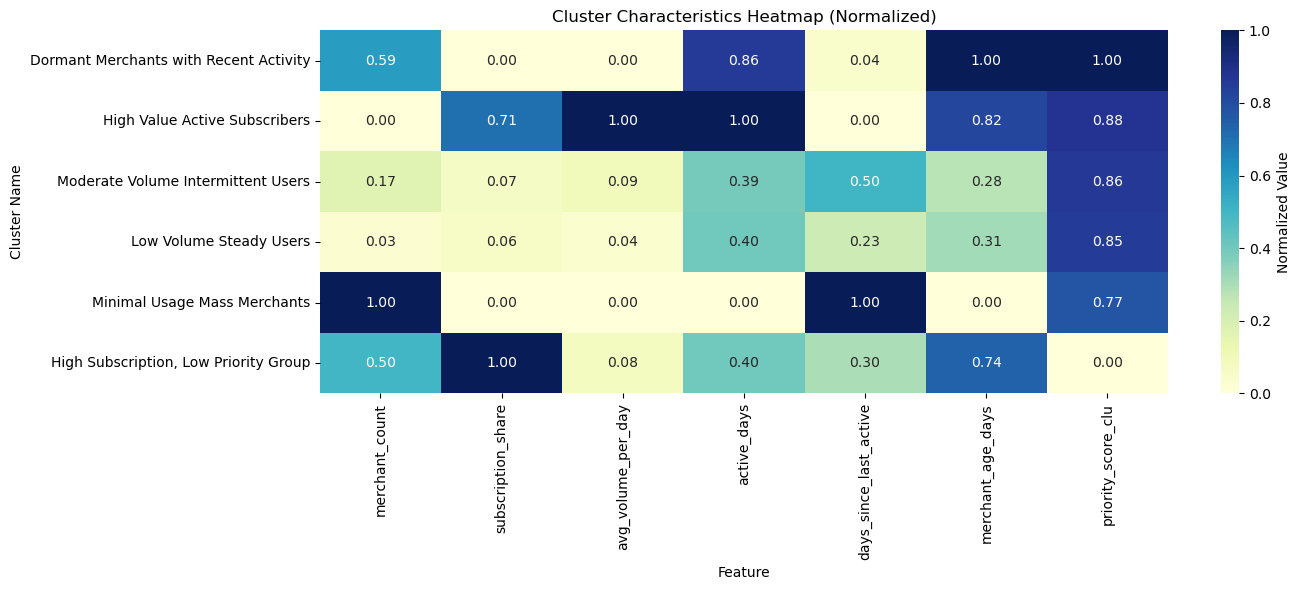

In [63]:
df=cluster_summary_sorted
df.set_index('cluster_name', inplace=True)

# Select numeric columns for heatmap
features = [
    'merchant_count', 'subscription_share', 'avg_volume_per_day',
    'active_days', 'days_since_last_active', 'merchant_age_days', 'priority_score_clu'
]

# Normalize for better visualization
df_normalized = (df[features] - df[features].min()) / (df[features].max() - df[features].min())

# Plot heatmap
plt.figure(figsize=(14, 6))
sns.heatmap(df_normalized, annot=True, cmap="YlGnBu", fmt=".2f", cbar_kws={'label': 'Normalized Value'})
plt.title("Cluster Characteristics Heatmap (Normalized)")
plt.ylabel("Cluster Name")
plt.xlabel("Feature")
plt.tight_layout()
plt.show()

## Composite Scoring

To prioritize clusters of merchants for targeted engagement, I developed a composite priority score by combining multiple behavioral and business relevant metrics. This scoring helps rank clusters based on their potential for subscription product adoption and overall value.

Objective

>Identify clusters of merchants that are:

>Actively transacting

>Recently engaged

>High-volume generators

>Not yet fully subscribed (to target for conversion)


In [54]:
merged_df['subscription_score_indiv'] = 1 - merged_df['subscription_share']
merged_df['volume_score_indiv'] = merged_df['avg_volume_per_day'] / merged_df['avg_volume_per_day'].max()
merged_df['activity_score_indiv'] = merged_df['active_days'] / merged_df['active_days'].max()
merged_df['recency_score_indiv'] = 1 - (merged_df['days_since_last_active'] / merged_df['days_since_last_active'].max())
merged_df['age_score_indiv'] = merged_df['merchant_age_days'] / merged_df['merchant_age_days'].max()

# Composite merchant-level score
merged_df['merchant_priority_score'] = (
    0.4 * merged_df['subscription_score_indiv'] +
    0.25 * merged_df['volume_score_indiv'] +
    0.2 * merged_df['activity_score_indiv'] +
    0.1 * merged_df['recency_score_indiv'] +
    0.05 * merged_df['age_score_indiv']
)

In [59]:
# Rank merchants by priority score
merged_df['merchant_rank'] = merged_df['merchant_priority_score'].rank(ascending=False)

# Or add tiers: High, Medium, Low
merged_df['merchant_priority_tier'] = pd.qcut(
    merged_df['merchant_priority_score'], 
    q=3, 
    labels=['Low', 'Medium', 'High']
)


,cluster,merchant_count,subscription_share,avg_volume_per_day,active_days,days_since_last_active,merchant_age_days,priority_score_clu
cluster_name,,,,,,,,
Dormant Merchants with Recent Activity,5,1753,0.01,3.63,299.71,8.48,1424.64,0.63
High Value Active Subscribers,2,153,0.69,3333.04,338.78,4.53,1293.20,0.57
Moderate Volume Intermittent Users,4,606,0.07,316.09,172.09,50.72,905.16,0.56
Low Volume Steady Users,3,233,0.06,120.20,175.08,25.90,932.57,0.55
Minimal Usage Mass Merchants,1,2866,0.01,0.87,64.01,96.81,707.67,0.52
"High Subscription, Low Priority Group",0,1503,0.97,270.10,175.28,32.09,1237.62,0.16


In [66]:
cluster_summary_sorted.reset_index(inplace=True)
merged_df = merged_df.merge(
    cluster_summary_sorted,
    on='cluster',
    how='left',
    suffixes=('', '_cluster')  # avoids overwriting merchant-level columns
)

In [68]:
filtered_df = merged_df[merged_df['subscription_share'] == 0]
top_candidates = filtered_df[filtered_df['merchant_priority_score'] >= 0.6]

top_candidates = top_candidates[
    (top_candidates['days_since_last_active'] < 90) &
    (top_candidates['avg_volume_per_day'] > 100) 
    # (top_candidates['industry'] == 'software')
# adjust threshold as needed
]

### We can also use merchant age and industry to filter top merchants

final_list = top_candidates[[
    'merchant', 'industry', 'business_size', 'country','cluster_name','total_volume',
    'avg_volume_per_day', 'active_days', 'days_since_last_active',
    'merchant_age_days', 'merchant_priority_score', 'priority_score_clu', 'cluster'
]].sort_values(by='merchant_priority_score', ascending=False)

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [69]:
top_n = 100
top_merchants = final_list.head(top_n)

total_volume_top_merchants = top_merchants['total_volume'].sum()/1000000
total_volume_of_non_subscribers=checkout_volume_m + payment_link_volume_m

print(f"Total volume for all non subscriber merchants: {total_volume_of_non_subscribers:.2f} million USD")
print(f"Total volume for top {top_n} identified merchants: {total_volume_top_merchants:.2f} million USD")

Total volume for all non subscriber merchants: 135.08 million USD
Total volume for top 100 identified merchants: 91.12 million USD


In [70]:
# Assume 'top_n_df' contains your top N recommended merchants
# and includes at least 'cluster' and 'total_volume' columns

# Group by cluster and summarize count and volume
top_clusters_summary = (
    top_merchants.groupby(['cluster','cluster_name'])
    .agg(
        merchant_count=('merchant', 'nunique'),
        total_volume_m=('total_volume', lambda x: round(x.sum() / 1_000_000, 2))
    )
    .reset_index()
    .sort_values(by='total_volume_m', ascending=False)
)

# Display summary
display(top_clusters_summary)


,cluster,cluster_name,merchant_count,total_volume_m
0,2,High Value Active Subscribers,31,73.45
2,4,Moderate Volume Intermittent Users,62,16.06
1,3,Low Volume Steady Users,7,1.62


The table above shows which clusters the top recommended merchants belong to, along with the total potential volume (in millions) they could bring if successfully converted to the Subscriptions product.

Key Insights
Cluster 2 (High-Potential Power Merchants), although smaller in count, represents the highest monetization potential due to very high average daily volume.

Cluster 4 (Young Active Niche) has the largest number of merchants in the top-N and could be targeted at scale.

Cluster 3 (High Subscription Share, Low Volume) might be already experimenting with Subscriptions but have low payment volume, indicating low overall opportunity.


In [71]:
##Export the list to a csv
final_list.to_csv(os.path.join(outputpath, "top_merchants_priority_list.csv"), index=False)